# Exploring Structure in Chinese Noun Embeddings

---

This project investigates how Chinese nouns organise in BERT’s embedding space, using clustering and dimensionality reduction to uncover underlying linguistic patterns. 

The goal was to explore whether semantic categories emerge naturally from contextual embeddings, and to what extent structural properties of Chinese, such as single-character morphology, influence the organisation of meaning.  

---

**This notebook examines single-character nouns in isolation**, using pre-computed clustering results exported from [**noun_clustering.ipynb**](noun_clustering.ipynb). The clustering file is not tracked in git but can be regenerated by running the other notebook.

## Data Preparation

### Load Clusters

In [4]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import os

# Load the clustering data
with open('data/noun_clustering_1000_28.pkl', 'rb') as f:
    clustering_data = pickle.load(f)

# Filter for cluster 15 (single-character nouns)
cluster_mask = clustering_data['cluster_labels'] == 15
singles = clustering_data['nouns_df'][cluster_mask].copy()
print(f"Single-character cluster size: {len(singles)}")

# Load the original dataframe to match indices
df_noun_top2500 = pd.read_csv('data/nouns_top2500.csv')

# Load or create original embeddings (768-dim BERT embeddings)
embeddings_file = 'data/noun_embeddings_2500.npy'

if os.path.exists(embeddings_file):
    print(f"Loading existing embeddings from {embeddings_file}")
    embeddings_original = np.load(embeddings_file)
    
    # Validate shape matches current dataframe
    if embeddings_original.shape[0] == len(df_noun_top2500):
        print(f"Loaded embeddings shape: {embeddings_original.shape}")
    else:
        print(f"Warning: Loaded embeddings ({embeddings_original.shape[0]}) don't match dataframe ({len(df_noun_top2500)})")
        print("Regenerating embeddings...")
        os.remove(embeddings_file)  # Remove mismatched file
        embeddings_original = None  # Force regeneration
else:
    print(f"Embeddings file not found. Generating new embeddings...")
    embeddings_original = None

if embeddings_original is None:
    print("Generating new embeddings...")
    model_name = "bert-base-chinese"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    
    model.eval()
    
    nouns = df_noun_top2500['Noun'].tolist()
    embeddings_list = []
    
    for i, noun in enumerate(nouns):
        inputs = tokenizer(noun, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        embeddings_list.append(emb)
        
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(nouns)} nouns...")
    
    embeddings_original = np.stack(embeddings_list)
    
    # Save embeddings for future use
    np.save(embeddings_file, embeddings_original)
    print(f"Saved embeddings to {embeddings_file}")
    print(f"Embeddings shape: {embeddings_original.shape}")

# Match cluster 15 nouns to their indices in the original embeddings
# Create a mapping from Noun to index in the original dataframe
noun_to_idx = {row['Noun']: idx for idx, row in df_noun_top2500.iterrows()}

# Get indices for single-character cluster
singles_indices = [noun_to_idx[noun] for noun in singles['Noun']]

# Extract original embeddings for cluster 15
embeddings_singles = embeddings_original[singles_indices]
print(f"Single-character cluster embeddings shape: {embeddings_singles.shape}")

# Fit PCA specifically on cluster 15 embeddings
pca_100_singles = PCA(n_components=100, random_state=42)
embeddings_singles_pca100 = pca_100_singles.fit_transform(embeddings_singles)

print(f"Single-character cluster PCA-100 embeddings shape: {embeddings_singles_pca100.shape}")
print(f"Explained variance ratio: {pca_100_singles.explained_variance_ratio_.sum():.4f}")

Single-character cluster size: 140
Loading existing embeddings from data/noun_embeddings_2500.npy
Loaded embeddings shape: (2500, 768)
Single-character cluster embeddings shape: (140, 768)
Single-character cluster PCA-100 embeddings shape: (140, 100)
Explained variance ratio: 0.9547


## Clustering Analysis

### Define Helper Functions

In [ ]:
def find_representative_nouns(embeddings, labels, nouns_df, n_clusters, n_representatives=25, return_dict=False):
    """
    Find the n closest nouns to each cluster centroid using KNN.
    
    Parameters:
        embeddings: embedding vectors
        labels: cluster labels
        nouns_df: dataframe with noun information
        n_clusters: number of clusters
        n_representatives: number of representative words per cluster
        return_dict: if True, return dict mapping cluster_id -> representatives
                     if False, return list of dicts with cluster_id, size, representatives
    """
    results_list = []
    
    for cluster_id in range(n_clusters):
        # Get all points in this cluster
        cluster_mask = labels == cluster_id
        cluster_embeddings = embeddings[cluster_mask]
        cluster_nouns = nouns_df[cluster_mask]
        
        if len(cluster_embeddings) == 0:
            results_list.append({
                'cluster_id': cluster_id,
                'size': 0,
                'representatives': []
            })
            continue
        
        # Calculate centroid
        centroid = cluster_embeddings.mean(axis=0).reshape(1, -1)
        
        # Use KNN to find closest nouns to centroid
        knn = NearestNeighbors(n_neighbors=min(n_representatives, len(cluster_embeddings)))
        knn.fit(cluster_embeddings)
        distances, indices = knn.kneighbors(centroid)
        
        # Get the representative nouns
        representative_nouns = cluster_nouns.iloc[indices[0]]
        
        results_list.append({
            'cluster_id': cluster_id,
            'size': cluster_mask.sum(),
            'representatives': representative_nouns[['Noun', 'English', 'Frequency']].to_dict('records')
        })
    
    if return_dict:
        # Convert to dict format for compatibility
        return {item['cluster_id']: item['representatives'] for item in results_list}
    else:
        return results_list

def run_clustering_grid_search(embeddings, cluster_range, method='both', random_state=42, n_init=10):
    """
    Run grid search over cluster counts for specified clustering method(s).
    
    Parameters:
        embeddings: embedding vectors
        cluster_range: range of cluster counts to test
        method: 'agglomerative', 'kmeans', or 'both'
        random_state: random seed for kmeans
        n_init: number of kmeans initializations
    
    Returns:
        dict with 'agg_scores' and/or 'kmeans_scores' lists
    """
    results = {}
    
    if method in ['agglomerative', 'both']:
        agg_scores = []
        for n_clusters in cluster_range:
            agg = AgglomerativeClustering(n_clusters=n_clusters)
            agg_labels = agg.fit_predict(embeddings)
            agg_silhouette = silhouette_score(embeddings, agg_labels)
            agg_scores.append(agg_silhouette)
        results['agg_scores'] = agg_scores
    
    if method in ['kmeans', 'both']:
        kmeans_scores = []
        for n_clusters in cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
            kmeans_labels = kmeans.fit_predict(embeddings)
            kmeans_silhouette = silhouette_score(embeddings, kmeans_labels)
            kmeans_scores.append(kmeans_silhouette)
        results['kmeans_scores'] = kmeans_scores
    
    return results

def plot_silhouette_comparison(cluster_range, scores_dict, optimal_dict, titles_dict, figsize=(16, 6)):
    """
    Plot silhouette scores for clustering methods.
    
    Parameters:
        cluster_range: range of cluster counts
        scores_dict: dict with keys like 'kmeans' and/or 'agg' mapping to score lists
        optimal_dict: dict with keys like 'kmeans' and/or 'agg' mapping to optimal cluster counts
        titles_dict: dict with keys like 'kmeans' and/or 'agg' mapping to plot titles
        figsize: figure size tuple
    """
    n_plots = len(scores_dict)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    if n_plots == 1:
        axes = [axes]
    
    colors = {'kmeans': 'steelblue', 'agg': 'orange'}
    
    for idx, (method, scores) in enumerate(scores_dict.items()):
        ax = axes[idx]
        ax.plot(cluster_range, scores, marker='o', linewidth=2, markersize=6, 
                color=colors.get(method, 'steelblue'))
        ax.axvline(x=optimal_dict[method], color='r', linestyle='--', alpha=0.7,
                   label=f'Optimal: {optimal_dict[method]}')
        ax.set_xlabel('Number of Clusters', fontsize=12)
        ax.set_ylabel('Silhouette Score', fontsize=12)
        ax.set_title(titles_dict[method], fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def display_clusters(cluster_data, labels, title, n_clusters):
    """Display clusters in a formatted way."""
    print("=" * 80)
    print(f"{title:^80s}")
    print("=" * 80)
    print()
    
    # Calculate cluster sizes
    cluster_sizes = {i: sum(labels == i) for i in range(n_clusters)}
    
    # Sort clusters by ID for consistent display
    for cluster_id in sorted(cluster_data.keys()):
        words = cluster_data[cluster_id]
        size = cluster_sizes.get(cluster_id, 0)
        
        print("─" * 80)
        print(f"Cluster {cluster_id:2d} (size: {size:3d})")
        print("─" * 80)
        
        for i, word in enumerate(words, 1):
            print(f"  {i:2d}. {word['Noun']:6s} - {word['English']:20s} (freq: {word['Frequency']:>6.0f})")
        print()

### Silhouette Score Analysis

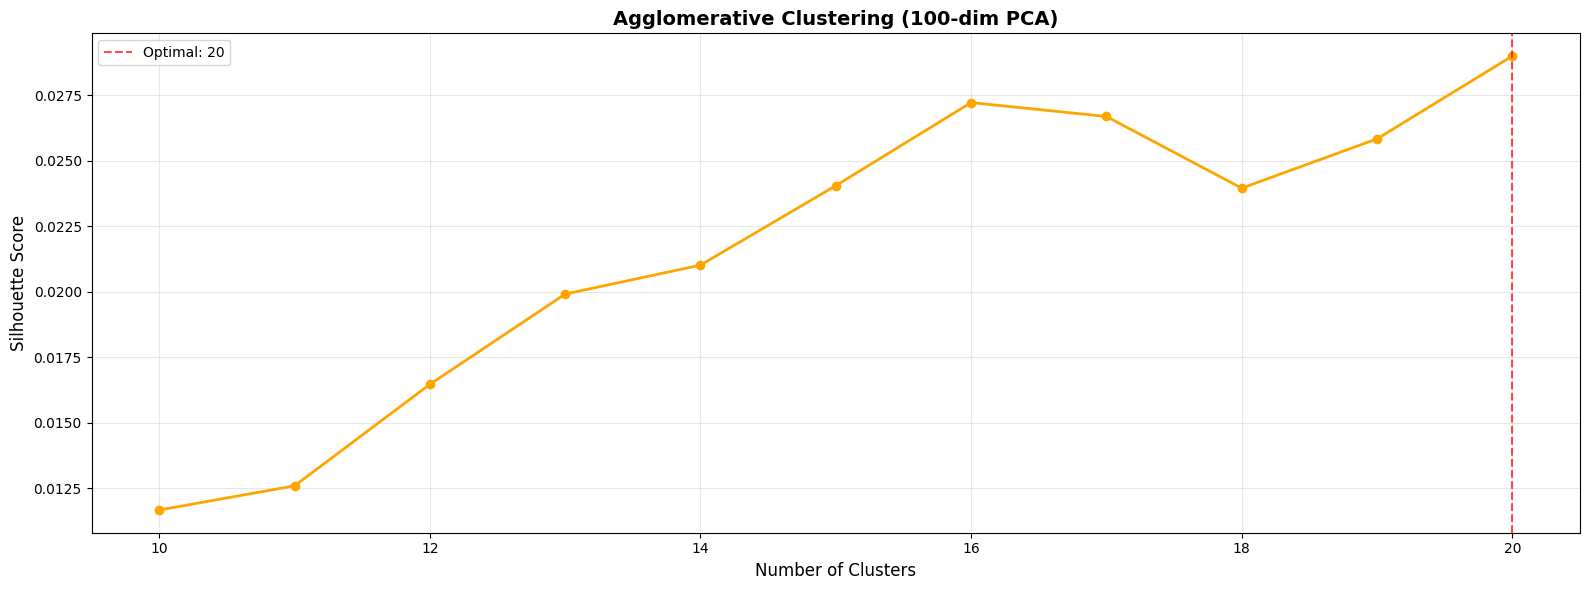

                     AGGLOMERATIVE CLUSTERING (100-DIM PCA)                     

────────────────────────────────────────────────────────────────────────────────
Cluster  0 (size:   8)
────────────────────────────────────────────────────────────────────────────────
   1. 房      - house                (freq:   2414)
   2. 屋      - room                 (freq:   1401)
   3. 室      - room                 (freq:   2526)
   4. 楼      - building             (freq:   3580)
   5. 店      - shop                 (freq:   4293)
   6. 城      - city                 (freq:   2428)
   7. 团      - group                (freq:    804)
   8. 塔      - tower                (freq:    940)

────────────────────────────────────────────────────────────────────────────────
Cluster  1 (size:  14)
────────────────────────────────────────────────────────────────────────────────
   1. 歌      - song                 (freq:   6285)
   2. 本      - book                 (freq:   1125)
   3. 货      - goods                (

In [15]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Grid search parameters
cluster_range = range(10, 21)

# Run grid search using helper function
search_results = run_clustering_grid_search(embeddings_singles_pca100, cluster_range, method='agglomerative')
agg_scores = search_results['agg_scores']

# Find optimal number of clusters
optimal_agg_idx = np.argmax(agg_scores)
optimal_agg_clusters = list(cluster_range)[optimal_agg_idx]

# Plot silhouette scores
plot_silhouette_comparison(
    cluster_range,
    {'agg': agg_scores},
    {'agg': optimal_agg_clusters},
    {'agg': 'Agglomerative Clustering (100-dim PCA)'}
)

# Fit optimal model
agg_optimal = AgglomerativeClustering(n_clusters=optimal_agg_clusters)
agg_optimal_labels = agg_optimal.fit_predict(embeddings_singles_pca100)

# Get top 25 words in each cluster
agg_top25 = find_representative_nouns(embeddings_singles_pca100, agg_optimal_labels, singles, optimal_agg_clusters, n_representatives=25, return_dict=True)

# Display results
display_clusters(agg_top25, agg_optimal_labels, "AGGLOMERATIVE CLUSTERING (100-DIM PCA)", optimal_agg_clusters)
print("\n\n")

## Results

Clustering single-character nouns by their embeddings produces semantically incoherent groupings with poor resolution, suggesting that BERT's representations fail to capture meaningful semantic structure within this morphologically constrained subspace.

**Organising single-character nouns by their radicals may provide a more linguistically grounded basis for understanding their representation.**